## Assignment || k-NN on  Amazon Reviews Dataset
#### By Rishiraj Adhikary For AppliedAIcourse.com || www.rishiraj.xyz@gmail.com

### Note
#### The amazon data used here is the cleaned and text preprocessed data. Hence, no deduplication or text-preprocessing is done here. Make sure your data is clean and without duplicate entries before you execute this notebook

## Objective
### Evaluating the value of k in k nearest neighbours and checking its accuracy

In [1]:
#initilaization for all the required packages
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc



from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation

/home/rishi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# using the SQLite Table to read data.
#final.sqlite is a cleaned deduped and preprocessed data
con = sqlite3.connect('final.sqlite') 


cleaned_data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con) 

positiveNegative = cleaned_data['Score'] #Keeping labels/class in a different variable so that we can use it latercleaned_data.shape
cleaned_data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


### We will have to reduce the data sets from 364K to 10K data sets of which 5K is positive and 5K is negative
#### This is done so as to speed up computation. 

In [3]:
#we will take first 1k positive reviews and first 1k negative reviews. Combine them to have a total of 2k text reviews
positiveData = cleaned_data[cleaned_data['Score'] == 'positive']
negativeData = cleaned_data[cleaned_data['Score'] == 'negative']
cleanedData_less = positiveData[:5000].append(negativeData[:5000])
len(cleanedData_less)
#the score corresponding to all 2k reviews
positiveNegativeLabel = cleanedData_less['Score']


### We will sort the data on the basis of the timestamp. This is necessary to do time-based splitting before applying K-NN

In [4]:
cleanedData_less.sort_values(by=['Time'], inplace=True, kind='quicksort', na_position='last')
positiveNegativeLabel = cleanedData_less['Score']


## Text to Vector Conversion Using Bag of Words. 


In [5]:
#positiveNegativeLabel = cleanedData_less['Score']
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(cleanedData_less['Text'].values)
final_counts.get_shape()
print(type(final_counts))

<class 'scipy.sparse.csr.csr_matrix'>


### Dividing data into train and test set for applying K-NN
SInce the data was sorted on basis of time, hence first 70% of data will be training data and rest30% will be test data. The line below accomplishes that

In [6]:
#70% training data and 30% test data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(final_counts, positiveNegativeLabel, test_size=0.3, random_state=0)

### Applying 10-fold cross validation on training data

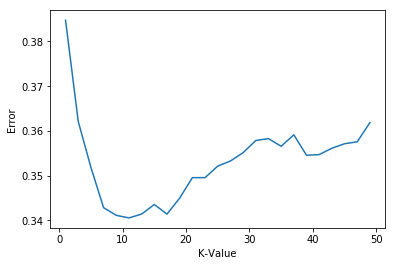


The optimal number of neighbors is 11.


In [7]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy') #accuracy measurement, not error
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

#plot the error curve
Y = np.array(MSE)
X = np.array(neighbors)

plt.plot(X,Y)
plt.ylabel('Error')
plt.xlabel('K-Value')
plt.show()

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)



#### The optimal k will be used as k-NN for the test data set to predict the response and evaluate accuracy


In [8]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

#Code for Confusion Matrix (Raw)

#TN = True Negative
#FP = False Positive
#FN = False Negative
#TP = True Positive

TP = TN = FP = FN = 0;

for i in range(len(pred)):
    if pred[i] == y_test.values[i]:
        if pred[i] == 'positive':
            TP = TP + 1;
        else:
            TN = TN + 1;
    elif y_test.values[i] == 'negative' and pred[i] == 'positive':
        FP = FP + 1;
    else:
        FN = FN + 1;


#TN + FP = Total Actual Negative Points
#FN + TP = Total Actual Positive Points

print("True Positive Rate = ", round((TP/(TP+FN))*100,2),"%" )
print("True Negative Rate = ", round((TN/(FP+TN))*100,2),"%" )
print("False Positive Rate = ", round((FP/(FP+TN))*100,2),"%" )
print("False Negative Rate = ", round((FN/(TP+FN))*100,2),"%" )

#Code For Confusion Matrix Using Sklearn
#he count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}.
from sklearn.metrics import confusion_matrix
print("\nConfusion Matrix Is Below.\n true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1}, lse positives is C_{0,1}")
confusion_matrix(y_test.values, pred)


The accuracy of the knn classifier for k = 11 is 66.866667%
True Positive Rate =  82.05 %
True Negative Rate =  50.89 %
False Positive Rate =  49.11 %
False Negative Rate =  17.95 %

Confusion Matrix Is Below.
 true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1}, lse positives is C_{0,1}


array([[ 744,  718],
       [ 276, 1262]])

## Result:
Usinng BOW, the accuracy attained is 66.87% with k as 11 in k-NN

## ---------------------------------------------------------------------------------------------------------------

## Text to Vector Conversion Using TF-IDF. 


In [9]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(cleanedData_less['Text'].values)
type(final_tf_idf)


scipy.sparse.csr.csr_matrix

### Dividing data into train and test set for applyting K-NN

In [10]:
### Dividing data into train and test set for applyting K-NN
#70% training data and 30% test data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(final_tf_idf, positiveNegativeLabel, test_size=0.3, random_state=0)


### Applying 3-fold cross validation on training data

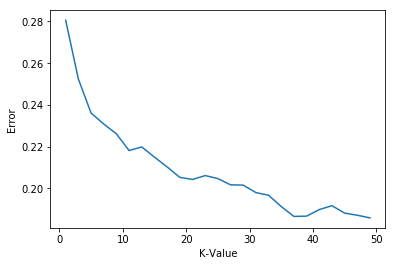


The optimal number of neighbors is 49.


In [11]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=3, scoring='accuracy') #accuracy measurement, not error
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

#plot the error curve
Y = np.array(MSE)
X = np.array(neighbors)

plt.plot(X,Y)
plt.ylabel('Error')
plt.xlabel('K-Value')
plt.show()

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

#### The optimal k will be used as k-NN for the test data set to predict the responnse and evaluate accuracy


In [12]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


#Code for Confusion Matrix

#TN = True Negative
#FP = False Positive
#FN = False Negative
#TP = True Positive

TP = TN = FP = FN = 0;

for i in range(len(pred)):
    if pred[i] == y_test.values[i]:
        if pred[i] == 'positive':
            TP = TP + 1;
        else:
            TN = TN + 1;
    elif y_test.values[i] == 'negative' and pred[i] == 'positive':
        FP = FP + 1;
    else:
        FN = FN + 1;


#TN + FP = Total Actual Negative Points
#FN + TP = Total Actual Positive Points

print("True Positive Rate = ", round((TP/(TP+FN))*100,2),"%" )
print("True Negative Rate = ", round((TN/(FP+TN))*100,2),"%" )
print("False Positive Rate = ", round((FP/(FP+TN))*100,2),"%" )
print("False Negative Rate = ", round((FN/(TP+FN))*100,2),"%" )

#Code For Confusion Matrix Using Sklearn
#he count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}.
from sklearn.metrics import confusion_matrix
print("\nConfusion Matrix Is Below.\n true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1}, lse positives is C_{0,1}")
confusion_matrix(y_test.values, pred)



The accuracy of the knn classifier for k = 49 is 82.533333%
True Positive Rate =  85.05 %
True Negative Rate =  79.89 %
False Positive Rate =  20.11 %
False Negative Rate =  14.95 %

Confusion Matrix Is Below.
 true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1}, lse positives is C_{0,1}


array([[1168,  294],
       [ 230, 1308]])

## Result:
Usinng TF-IDF, the accuracy attained is 82.53% with k as 49 in k-NN

### --------------------------------------------------------------------------------------------------------------------------------

## Text to Vector Conversion Using Average Word2Vec. 


### Making Our Own Word2vec Model
#### Using Google's Model Is Computationally Impossible In The System Where This Notebook Was Written

In [13]:
# Train our own Word2Vec model using your own text corpus
list_of_sent = []
import gensim
for sent in cleanedData_less['Text'].values:
    filtered_sentence=[]
    for w in sent.split():
        filtered_sentence.append(w.lower())
    list_of_sent.append(filtered_sentence)

print(cleanedData_less['Text'].values[0])
print("*****************************************************************")
print(list_of_sent[0])
print(type(list_of_sent))

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
*****************************************************************
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud.', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', "we're", 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain.', "he's", 'learned', 'about', 'whales,', 'india,', 'drooping', 'roses:', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all.', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', '

In [14]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    
words = list(w2v_model.wv.vocab)
print(len(words))

9815


In [15]:
#testing the w2v model
w2v_model.wv.most_similar('tasty')

[('sweet,', 0.9408867359161377),
 ('sweet.', 0.9270947575569153),
 ('overpowering', 0.9138548970222473),
 ('strong,', 0.909695029258728),
 ('flavorful', 0.9078221321105957),
 ('tasting.', 0.906448483467102),
 ('flavorful.', 0.9062829613685608),
 ('good!', 0.9022498726844788),
 ('creamy', 0.90223228931427),
 ('tasty,', 0.9018855690956116)]

#### It appears that our word2vec model is not satisfactory. It is eveident from the choice of similar words being output for words like 'like' and 'tasty'. We will still go ahead with the t-SNE visualization but we cannot expect much improvement over BOW and TF-IDF

In [16]:
# text to vector conversion using average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
print(type(sent_vectors))

10000
50
<class 'list'>


### Dividing data into train and test set for applyting K-NN

In [17]:
### Dividing data into train and test set for applyting K-NN
#70% training data and 30% test data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(sent_vectors, positiveNegativeLabel, test_size=0.3, random_state=0)


### Applying 3-fold cross validation on training data

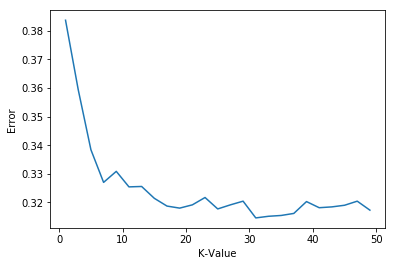


The optimal number of neighbors is 31.


In [18]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=3, scoring='accuracy') #accuracy measurement, not error
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

#plot the error curve
Y = np.array(MSE)
X = np.array(neighbors)

plt.plot(X,Y)
plt.ylabel('Error')
plt.xlabel('K-Value')
plt.show()

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

#### The optimal k will be used as k-NN for the test data set to predict the response and evaluate accuracy


In [20]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)


# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

#Code for Confusion Matrix

#TN = True Negative
#FP = False Positive
#FN = False Negative
#TP = True Positive

TP = TN = FP = FN = 0;

for i in range(len(pred)):
    if pred[i] == y_test.values[i]:
        if pred[i] == 'positive':
            TP = TP + 1;
        else:
            TN = TN + 1;
    elif y_test.values[i] == 'negative' and pred[i] == 'positive':
        FP = FP + 1;
    else:
        FN = FN + 1;


#TN + FP = Total Actual Negative Points
#FN + TP = Total Actual Positive Points

print("True Positive Rate = ", round((TP/(TP+FN))*100,2),"%" )
print("True Negative Rate = ", round((TN/(FP+TN))*100,2),"%" )
print("False Positive Rate = ", round((FP/(FP+TN))*100,2),"%" )
print("False Negative Rate = ", round((FN/(TP+FN))*100,2),"%" )

#Code For Confusion Matrix Using Sklearn
#he count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}.
from sklearn.metrics import confusion_matrix
print("\nConfusion Matrix Is Below.\n true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1}, lse positives is C_{0,1}")
confusion_matrix(y_test.values, pred)


The accuracy of the knn classifier for k = 31 is 68.266667%
True Positive Rate =  62.87 %
True Negative Rate =  73.94 %
False Positive Rate =  26.06 %
False Negative Rate =  37.13 %

Confusion Matrix Is Below.
 true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1}, lse positives is C_{0,1}


array([[1081,  381],
       [ 571,  967]])

## Result:
Usinng word2vec, the accuracy attained is 68.26% with k as 31 in k-NN

## ---------------------------------------------------------------------------------------------------------------------

## Text to Vector Conversion Using TF--IDF weighted Word2Vec. 


In [13]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(cleanedData_less['Text'].values)
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
len(tfidf_sent_vectors)
print(type(tfidf_sent_vectors))

<class 'list'>


### Dividing data into train and test set for applyting K-NN

In [14]:
### Dividing data into train and test set for applyting K-NN
#70% training data and 30% test data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(tfidf_sent_vectors, positiveNegativeLabel, test_size=0.3, random_state=0)


### Applying 3-fold cross validation on training data

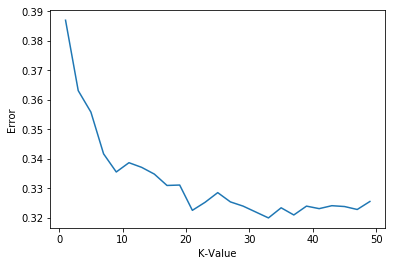


The optimal number of neighbors is 33.


In [15]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=3, scoring='accuracy') #accuracy measurement, not error
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

#plot the error curve
Y = np.array(MSE)
X = np.array(neighbors)

plt.plot(X,Y)
plt.ylabel('Error')
plt.xlabel('K-Value')
plt.show()

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

#### The optimal k will be used as k-NN for the test data set to predict the response and evaluate accuracy


In [16]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)


# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

#Code for Confusion Matrix

#TN = True Negative
#FP = False Positive
#FN = False Negative
#TP = True Positive

TP = TN = FP = FN = 0;

for i in range(len(pred)):
    if pred[i] == y_test.values[i]:
        if pred[i] == 'positive':
            TP = TP + 1;
        else:
            TN = TN + 1;
    elif y_test.values[i] == 'negative' and pred[i] == 'positive':
        FP = FP + 1;
    else:
        FN = FN + 1;


#TN + FP = Total Actual Negative Points
#FN + TP = Total Actual Positive Points

print("True Positive Rate = ", round((TP/(TP+FN))*100,2),"%" )
print("True Negative Rate = ", round((TN/(FP+TN))*100,2),"%" )
print("False Positive Rate = ", round((FP/(FP+TN))*100,2),"%" )
print("False Negative Rate = ", round((FN/(TP+FN))*100,2),"%" )


The accuracy of the knn classifier for k = 33 is 68.233333%
True Positive Rate =  61.44 %
True Negative Rate =  75.38 %
False Positive Rate =  24.62 %
False Negative Rate =  38.56 %


## Result:
Usinng TF-IDF weighted word2vec, the accuracy attained is 68.23% with k as 33 in k-NN

## ------------------------------------------------------------------------------------------------------------------

## Conclusion
#### 1. From the above analysis and result, we saw that the best accuracy attained on the test data was 82.53% with K value as 49. This K value was obtained from vectors generated using TF-IDF.

#### 2. For TF-IDF, the True Positive Rate obtained is 85.05% and the False Positive Rate of 20.11%. These are the best rates obtained across all the models.

#### 3. There was no improvement, infact there was detoriation in the accuracy when vectors were obtained using average word2vec and tf-idf weighted word2vec. This was perhaps because our model on word2vec was not perfect. This was noted above also.

<img src="amazonFR-KNN-report.png">


Point to note: We applied 10 fold cross validation on training data where the vectors were generated using Bag of words. For all other, we have used 3 fold cross validation to speed up computation. 
